In [1]:


!pip install transformers datasets evaluate scikit-learn accelerate -q

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [2]:

dataset = load_dataset("imdb")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [3]:


checkpoint_distilbert = "distilbert-base-uncased"
checkpoint_minilm = "microsoft/MiniLM-L12-H384-uncased"
checkpoint_albert = "albert-base-v2"

tokenizer = AutoTokenizer.from_pretrained(checkpoint_distilbert)

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_dataset = dataset.map(preprocess, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:


accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels),
        "precision": precision.compute(predictions=preds, references=labels, average="binary"),
        "recall": recall.compute(predictions=preds, references=labels, average="binary"),
        "f1": f1.compute(predictions=preds, references=labels, average="binary")
    }



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-596165818.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
500,0.321200
1000,0.249300
1500,0.224600
2000,0.162700
2500,0.147400
3000,0.152400
3500,0.101100
4000,0.087100
4500,0.084000


Trainer is attempting to log a value of "{'accuracy': 0.93224}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9289456970466815}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.93608}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9324992030602487}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2831557095050812, 'eval_accuracy': {'accuracy': 0.93224}, 'eval_precision': {'precision': 0.9289456970466815}, 'eval_recall': {'recall': 0.93608}, 'eval_f1': {'f1': 0.9324992030602487}, 'eval_runtime': 360.466, 'eval_samples_per_second': 69.355, 'eval_steps_per_second': 4.336, 'epoch': 3.0}


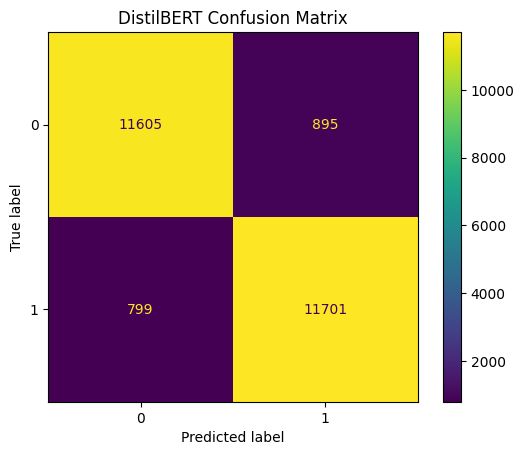

In [5]:


from transformers import TrainingArguments, Trainer

model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_distilbert, num_labels=2
)

training_args = TrainingArguments(
    output_dir="./results_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,
    do_eval=True
)

trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# TRAIN
trainer_distilbert.train()

# EVAL
results_distilbert = trainer_distilbert.evaluate()
print(results_distilbert)

preds_output = trainer_distilbert.predict(tokenized_dataset["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("DistilBERT Confusion Matrix")
plt.show()


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2021870929.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_minilm = Trainer(


Step,Training Loss
500,0.353500
1000,0.255000
1500,0.220300
2000,0.187400
2500,0.168200
3000,0.171700
3500,0.134700
4000,0.128400
4500,0.130400


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Trainer is attempting to log a value of "{'accuracy': 0.93744}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9338305299904792}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9416}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9376991714467814}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


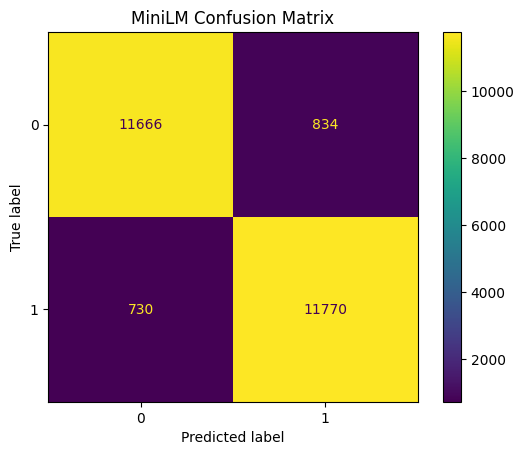

In [6]:


tokenizer_minilm = AutoTokenizer.from_pretrained(checkpoint_minilm)

tokenized_dataset_minilm = dataset.map(
    lambda batch: tokenizer_minilm(batch["text"], truncation=True, max_length=512),
    batched=True
)

model_minilm = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_minilm, num_labels=2
)

trainer_minilm = Trainer(
    model=model_minilm,
    args=training_args,
    train_dataset=tokenized_dataset_minilm["train"],
    eval_dataset=tokenized_dataset_minilm["test"],
    tokenizer=tokenizer_minilm,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_minilm),
    compute_metrics=compute_metrics,
)

trainer_minilm.train()


results_minilm = trainer_minilm.evaluate()
results_minilm


preds_output = trainer_minilm.predict(tokenized_dataset_minilm["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("MiniLM Confusion Matrix")
plt.show()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2996015496.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_albert = Trainer(


Step,Training Loss
500,0.306000
1000,0.259800
1500,0.229700
2000,0.178600
2500,0.171500
3000,0.174700
3500,0.115100
4000,0.099500
4500,0.112600


Trainer is attempting to log a value of "{'accuracy': 0.94392}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9426451818761965}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.94536}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9440006390797252}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


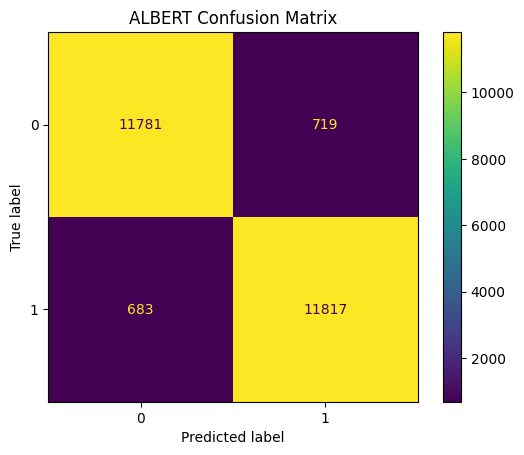

In [7]:


tokenizer_albert = AutoTokenizer.from_pretrained(checkpoint_albert)

tokenized_dataset_albert = dataset.map(
    lambda batch: tokenizer_albert(batch["text"], truncation=True),
    batched=True
)

model_albert = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_albert, num_labels=2
)

trainer_albert = Trainer(
    model=model_albert,
    args=training_args,
    train_dataset=tokenized_dataset_albert["train"],
    eval_dataset=tokenized_dataset_albert["test"],
    tokenizer=tokenizer_albert,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_albert),
    compute_metrics=compute_metrics,
)

trainer_albert.train()


results_albert = trainer_albert.evaluate()
results_albert


preds_output = trainer_albert.predict(tokenized_dataset_albert["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("ALBERT Confusion Matrix")
plt.show()


In [8]:


import time
import torch
import numpy as np
import psutil
import os
from datasets import Dataset

print("=== Efficiency Metrics ===")


model_params = sum(p.numel() for p in model_distilbert.parameters())
model_size_mb = model_params * 4 / (1024 * 1024)  # FP32 = 4 bytes
print(f"Model Size: {model_size_mb:.2f} MB")


train_time = None
for entry in reversed(trainer_distilbert.state.log_history):
    if "train_runtime" in entry:
        train_time = entry["train_runtime"]
        break

if train_time is None:
    print("Training Time: Not available in logs.")
else:
    print(f"Training Time: {train_time:.2f} seconds")


test_subset = tokenized_dataset["test"].select(range(200))

start = time.time()
pred_output = trainer_distilbert.predict(test_subset)
end = time.time()

inference_time_ms = ((end - start) / len(test_subset)) * 1000
print(f"Inference Time Per Sample: {inference_time_ms:.4f} ms")


throughput = len(test_subset) / (end - start)
print(f"Throughput: {throughput:.2f} samples/sec")


process = psutil.Process(os.getpid())
ram_usage_mb = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage During Evaluation: {ram_usage_mb:.2f} MB")


if torch.cuda.is_available():
    gpu_mem = torch.cuda.memory_allocated(0) / (1024 * 1024)
    print(f"GPU Memory Allocated: {gpu_mem:.2f} MB")
else:
    print("GPU Not Available (Running on CPU)")

GPU_TDP = 70  # Nvidia T4
energy_joules = GPU_TDP * (train_time if train_time else 0)
print(f"Approx Energy Used (Training): {energy_joules:.2f} Joules")


=== Efficiency Metrics ===
Model Size: 255.41 MB
Training Time: 3715.63 seconds


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Inference Time Per Sample: 14.5831 ms
Throughput: 68.57 samples/sec
RAM Usage During Evaluation: 2862.31 MB
GPU Memory Allocated: 1309.59 MB
Approx Energy Used (Training): 260093.83 Joules


In [9]:

import time
import torch
import numpy as np
import psutil
import os

print("=== Efficiency Metrics — MiniLM ===")


model_params = sum(p.numel() for p in model_minilm.parameters())
model_size_mb = model_params * 4 / (1024 * 1024)  # FP32 = 4 bytes
print(f"Model Size: {model_size_mb:.2f} MB")

train_time = getattr(trainer_minilm.state, "train_runtime", None)
if train_time:
    print(f"Training Time: {train_time:.2f} seconds")
else:
    print("Training Time: Not available")


test_samples = tokenized_dataset_minilm["test"].select(range(200))

start = time.time()
pred_output = trainer_minilm.predict(test_samples)
end = time.time()

inference_time_ms = ((end - start) / len(test_samples)) * 1000
print(f"Inference Time Per Sample: {inference_time_ms:.4f} ms")



throughput = len(test_samples) / (end - start)
print(f"Throughput: {throughput:.2f} samples/sec")


process = psutil.Process(os.getpid())
ram_usage_mb = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage During Evaluation: {ram_usage_mb:.2f} MB")


if torch.cuda.is_available():
    gpu_mem = torch.cuda.memory_allocated(0) / (1024 * 1024)
    print(f"GPU Memory Allocated: {gpu_mem:.2f} MB")
else:
    print("GPU not available — running on CPU.")

GPU_TDP = 70
energy_joules = (train_time if train_time else 0) * GPU_TDP
print(f"Approx Energy Used (Training): {energy_joules:.2f} joules")


=== Efficiency Metrics — MiniLM ===
Model Size: 127.26 MB
Training Time: Not available


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Inference Time Per Sample: 10.1062 ms
Throughput: 98.95 samples/sec
RAM Usage During Evaluation: 2862.38 MB
GPU Memory Allocated: 1309.59 MB
Approx Energy Used (Training): 0.00 joules


In [10]:


print("=== Efficiency Metrics — ALBERT ===")

params = sum(p.numel() for p in model_albert.parameters())
print(f"Model Size: {params * 4 / (1024 * 1024):.2f} MB")


train_time = getattr(trainer_albert.state, "train_runtime", None)
print(f"Training Time: {train_time if train_time else 'Not available'}")


test_samples = tokenized_dataset_albert["test"].select(range(200))

start = time.time()
pred_output = trainer_albert.predict(test_samples)
end = time.time()

inference_time_ms = ((end - start) / len(test_samples)) * 1000
print(f"Inference Time Per Sample: {inference_time_ms:.4f} ms")


throughput = len(test_samples) / (end - start)
print(f"Throughput: {throughput:.2f} samples/sec")


process = psutil.Process(os.getpid())
ram_mb = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage During Evaluation: {ram_mb:.2f} MB")


if torch.cuda.is_available():
    gpu_mem = torch.cuda.memory_allocated(0) / (1024 * 1024)
    print(f"GPU Memory Allocated: {gpu_mem:.2f} MB")
else:
    print("GPU not available — running on CPU.")


GPU_TDP = 70
energy = (train_time if train_time else 0) * GPU_TDP
print(f"Approx Energy Used (Training): {energy:.2f} Joules")


=== Efficiency Metrics — ALBERT ===
Model Size: 44.58 MB
Training Time: Not available


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Inference Time Per Sample: 32.1755 ms
Throughput: 31.08 samples/sec
RAM Usage During Evaluation: 2862.38 MB
GPU Memory Allocated: 1309.59 MB
Approx Energy Used (Training): 0.00 Joules
